In [2]:
from google.colab import drive # type: ignore
import pandas as pd;
drive.mount('/content/mdrive/')
data = pd.read_csv('/content/mdrive/MyDrive/full_df.csv')  # ← عدلي اسم الملف

Drive already mounted at /content/mdrive/; to attempt to forcibly remount, call drive.mount("/content/mdrive/", force_remount=True).


In [3]:
print(data.head())
print(data.info())
print(data.describe())
print("Duplicated rows:", data.duplicated().sum())
print("Missing values:\n", data.isnull().sum())


   ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   4           53        Male  4_left.jpg  4_right.jpg   
4   5           50      Female  5_left.jpg  5_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
4             moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
0                           normal fundus  0  0  0  1  0  0  0  0   
1                           normal fundus  1  0  0  0  0  0  0  0   
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1   
3       mild nonproliferative re

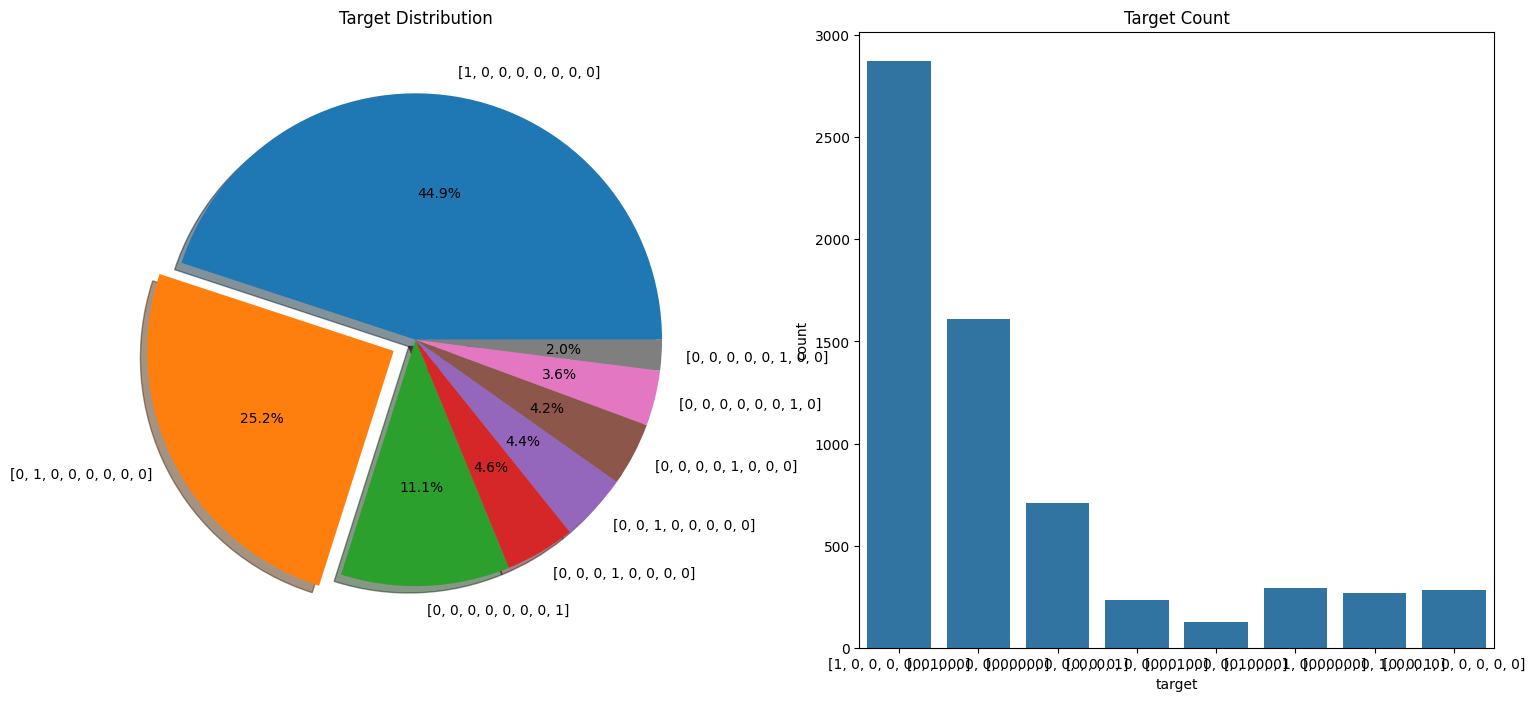

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

target_counts = data['target'].value_counts()
num_classes = len(target_counts)
explode = [0.1 if i == 1 else 0 for i in range(num_classes)]  # نضع انفجار للـ class الإيجابي فقط

f, ax = plt.subplots(1, 2, figsize=(18, 8))
target_counts.plot.pie(explode=explode, autopct="%1.1f%%", ax=ax[0], shadow=True)
ax[0].set_title('Target Distribution')
ax[0].set_ylabel('')

sns.countplot(x='target', data=data, ax=ax[1])
ax[1].set_title('Target Count')
plt.show()


In [6]:
drop_cols = ['ID', 'Left-Fundus', 'Right-Fundus', 'Left-Diagnostic Keywords',
             'Right-Diagnostic Keywords', 'filepath', 'labels', 'filename']
data = data.drop(columns=drop_cols)

# Convert 'Patient Sex' to numerical
data['Patient Sex'] = data['Patient Sex'].map({'M': 0, 'F': 1})  # أو استخدمي pd.get_dummies لو في أكثر من فئة


In [7]:
X = data.drop(columns='target')
y = data['target']


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)



In [15]:
data = data.dropna()


In [16]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# pipeline لمعالجة البيانات المفقودة + التوحيد
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # أو median أو most_frequent حسب طبيعة البيانات
    ('scaler', StandardScaler())
])

X_preprocessed = pipeline.fit_transform(X)


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Patient Sex']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [18]:
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression

svm_clf = SVC(kernel='linear')
sgd_clf = SGDClassifier(random_state=42)
log_reg_clf = LogisticRegression(random_state=42)

svm_clf.fit(X_train, y_train)
sgd_clf.fit(X_train, y_train)
log_reg_clf.fit(X_train, y_train)


LogisticRegression(random_state=42)

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

for model, name in zip([svm_clf, sgd_clf, log_reg_clf], ['SVM', 'SGD', 'LogReg']):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    print(f'{name} - Train Accuracy: {accuracy_score(y_train, train_pred):.4f}')
    print(f'{name} - Test Accuracy: {accuracy_score(y_test, test_pred):.4f}')

    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring="accuracy")
    print(f'{name} - Cross-Validation Accuracy: {cv_scores.mean():.4f}')


SVM - Train Accuracy: 0.8355
SVM - Test Accuracy: 0.8092
SVM - Cross-Validation Accuracy: 0.8306
SGD - Train Accuracy: 0.8304
SGD - Test Accuracy: 0.8030
SGD - Cross-Validation Accuracy: 0.8287
LogReg - Train Accuracy: 0.8357
LogReg - Test Accuracy: 0.8084
LogReg - Cross-Validation Accuracy: 0.8308
